In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [4]:
# Load data and parse dates (handling mixed date formats)
df = pd.read_csv(r"Supermart Grocery Sales - Retail Analytics Dataset.csv", dtype=str)
df.head(5)

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.8,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.2,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.6,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [5]:
parsed_dates = []
for date_str in df['Order Date']:
    if '-' in date_str:     # format: dd-mm-yyyy
        parsed_dates.append(pd.to_datetime(date_str, format='%d-%m-%Y'))
    elif '/' in date_str:   # format: mm/dd/yyyy
        parsed_dates.append(pd.to_datetime(date_str, format='%m/%d/%Y'))
    else:
        parsed_dates.append(pd.NaT)
df['Order Date'] = pd.to_datetime(parsed_dates)


In [6]:
# Convert numeric columns
df['Sales'] = pd.to_numeric(df['Sales'])
df['Discount'] = pd.to_numeric(df['Discount'])
df['Profit'] = pd.to_numeric(df['Profit'])


In [7]:
# Extract month, year, day from Order Date
df['Order Month'] = df['Order Date'].dt.month
df['Order Year']  = df['Order Date'].dt.year
df['Order Day']   = df['Order Date'].dt.day


In [8]:
# Encode categorical columns
le = LabelEncoder()
for col in ['Category','Sub Category','City','Region']:
    df[col] = le.fit_transform(df[col])


In [9]:
# Drop non-feature columns
df_clean = df.drop(['Order ID','Customer Name','State'], axis=1)
df_clean.to_csv("supermart_cleaned.csv", index=False)


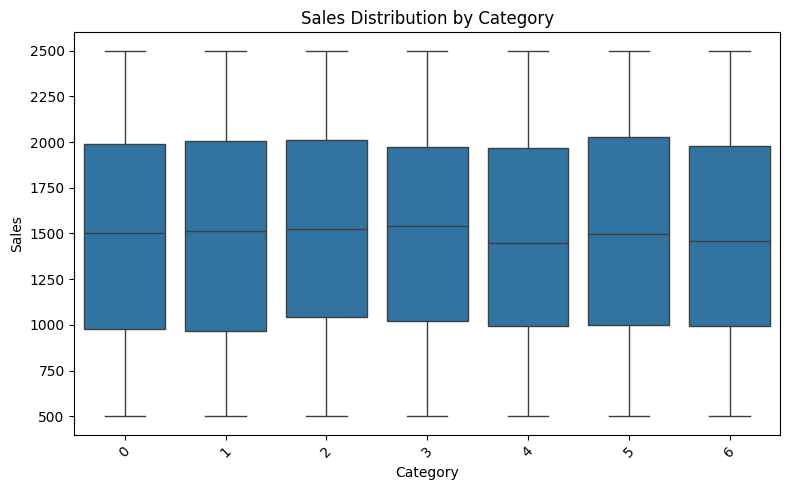

In [10]:
# Boxplot: Distribution of Sales by Category
plt.figure(figsize=(8,5))
sns.boxplot(x='Category', y='Sales', data=df)
plt.xticks(rotation=45)
plt.title('Sales Distribution by Category')
plt.ylabel('Sales')
plt.xlabel('Category')
plt.tight_layout()
plt.show()


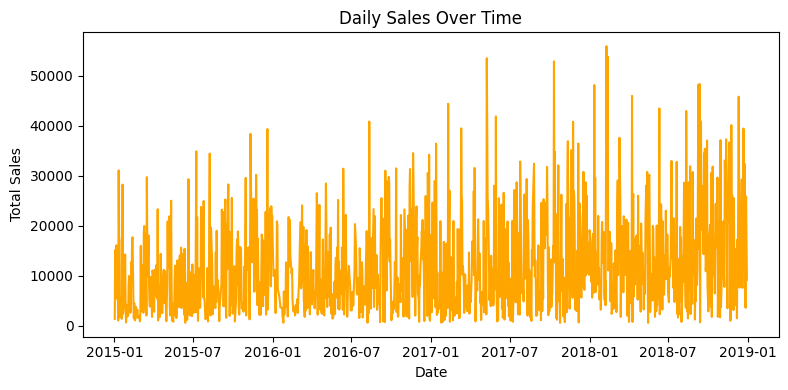

In [12]:
# Time series: Daily and monthly total sales
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
plt.figure(figsize=(8,4))
sns.lineplot(data=daily_sales, x='Order Date', y='Sales', color='orange')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()


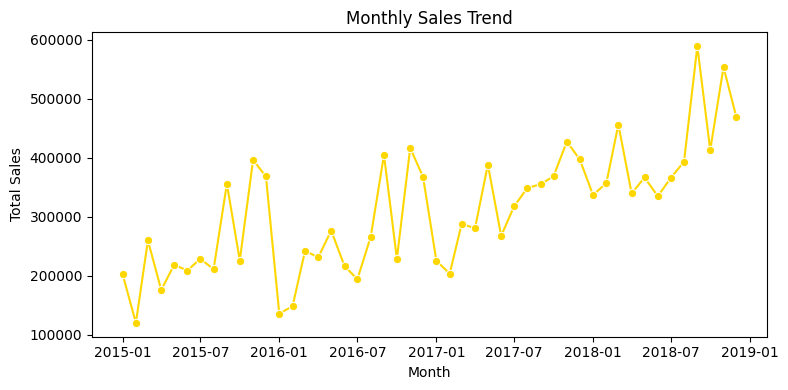

In [13]:
monthly_sales = df.groupby(df['Order Date'].dt.to_period('M'))['Sales'].sum().reset_index()
monthly_sales['Order Date'] = monthly_sales['Order Date'].dt.to_timestamp()
plt.figure(figsize=(8,4))
sns.lineplot(data=monthly_sales, x='Order Date', y='Sales', marker='o', color='gold')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()


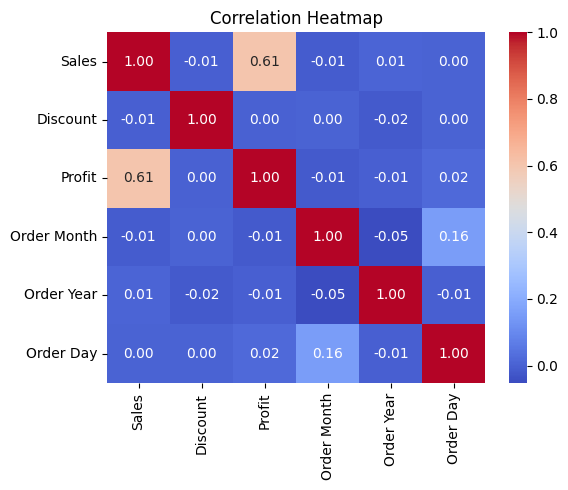

In [14]:
# Correlation heatmap of numeric features
numeric_cols = ['Sales','Discount','Profit','Order Month','Order Year','Order Day']
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [15]:
# Prepare features and target
features = ['Category','Sub Category','City','Region','Discount','Profit',
            'Order Month','Order Year','Order Day']
X = df_clean[features]
y = df_clean['Sales']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Standardize numeric features (scikit-learn scaler applies to all columns here)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Model training
lr  = LinearRegression().fit(X_train_scaled, y_train)
rf  = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_scaled, y_train)
xgb = XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train_scaled, y_train)

# Predictions
y_pred_lr  = lr.predict(X_test_scaled)
y_pred_rf  = rf.predict(X_test_scaled)
y_pred_xgb = xgb.predict(X_test_scaled)


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

models = {'Linear Regression': (y_pred_lr, lr),
          'Random Forest'   : (y_pred_rf, rf),
          'XGBoost'         : (y_pred_xgb, xgb)}

for name, (y_pred, model) in models.items():
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    print(f"{name:15s} -> MSE = {mse:.2f},  R² = {r2:.2f}")


Linear Regression -> MSE = 212968.92,  R² = 0.35
Random Forest   -> MSE = 217886.20,  R² = 0.34
XGBoost         -> MSE = 249450.95,  R² = 0.24


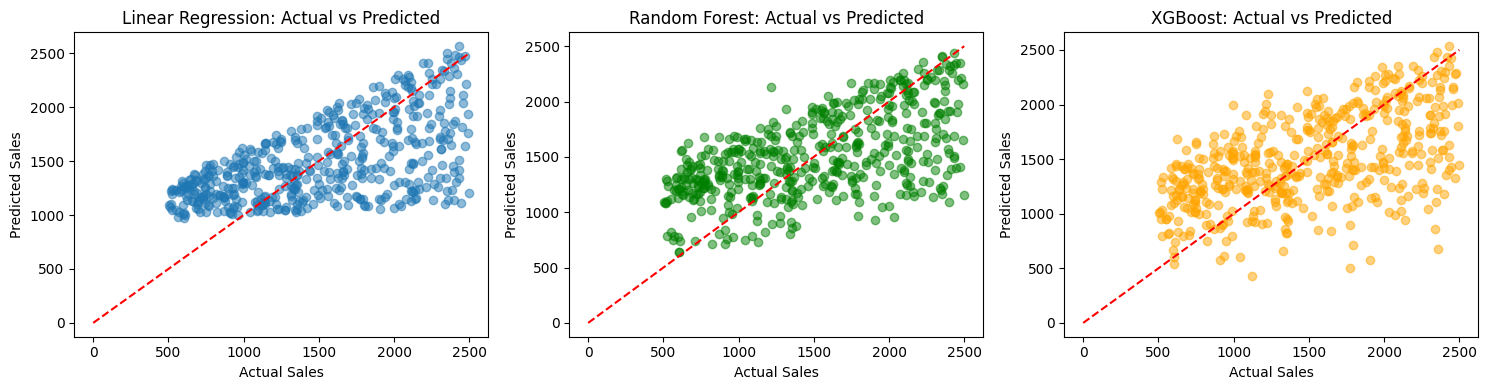

In [18]:
# Sample a subset for plotting clarity
idx = np.random.choice(len(y_test), size=500, replace=False)
y_true = y_test.values[idx]
y_pred_lr_sm  = y_pred_lr[idx]
y_pred_rf_sm  = y_pred_rf[idx]
y_pred_xgb_sm = y_pred_xgb[idx]

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(y_true, y_pred_lr_sm, alpha=0.5)
plt.plot([0, max(y_true)], [0, max(y_true)], 'r--')
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Sales"); plt.ylabel("Predicted Sales")

plt.subplot(1,3,2)
plt.scatter(y_true, y_pred_rf_sm, alpha=0.5, color='green')
plt.plot([0, max(y_true)], [0, max(y_true)], 'r--')
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Sales"); plt.ylabel("Predicted Sales")

plt.subplot(1,3,3)
plt.scatter(y_true, y_pred_xgb_sm, alpha=0.5, color='orange')
plt.plot([0, max(y_true)], [0, max(y_true)], 'r--')
plt.title("XGBoost: Actual vs Predicted")
plt.xlabel("Actual Sales"); plt.ylabel("Predicted Sales")

plt.tight_layout()
plt.show()
